# Stoneburner, Kurt
- ## DSC 530 - Week 10

In [1]:
# //****************************************************************************************
# //*** Set Working Directory to thinkstats folder.
# //*** This pseudo-relative path call should work on all Stoneburner localized projects. 
# //****************************************************************************************

import os
import sys
workingPath = os.getcwd().replace("coding", "ThinkStats2\\code")
sys.path.insert(1, workingPath)
os.chdir(workingPath)

In [2]:
# //*** Imports and Load Data
#import nsfg
import thinkstats2
import thinkplot
#import first
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
#//*** Add an index field that matches the index to help with reindexing errors
transactions['dex'] = transactions.index

#//*** Build empty array to hold average daily price 
mt_arr=np.empty(len(transactions));mt_arr.fill(np.nan)
#transactions['ppg_avg_day'] = mt_arr


transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon,dex
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870,0
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820,1
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258,2
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521,3
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983,4


In [3]:
#//*********************************************************************
#//*** Quick regression model results using patsy formula.
#//*********************************************************************
#//*** input_dict kwargs:
#//*** summary (boolean) - Display a summary evaluation of the model
#//*** pval (boolean) - Display the p-value of the model
#//*** getrsquared (boolean) - returns the r**2 value of the model
#//*** getpvalue (boolean) - returns the p value of the model
#//*** getmodel (boolean) - returns the model
#//*** method (string) - model type to run
#//***       ols (default) - Ordinary Least Squares (linear regression)
#//***       poisson - Poisson regression
#//***       logit - logistic regression.
#//*** Single output are returned as a single tyoe
#//*** Multiple outots return as a string in the following order: rsquared, pvalue, model
#//*****************************************************************************************
def qmodel_patsy_ols(df,formula,**input_dict):
    
    #//*** Check that Statsmodel is loaded.
    #//*** Requires the sys library which imports if not in use.
    try:
        if 'sys' not in sys.modules:
            print(f"{sys.modules}")
        else:
            import sys
    except:
        import sys

    if 'sm' not in sys.modules:
        try:
            import statsmodels.api as sm
        except:
            print(f"This Function requires the 'statsmodel' library to be installed")
            return
    if 'sm' not in sys.modules:
        try:
            import statsmodels.formula.api as smf
        except:
            print(f"This Function requires the 'statsmodel' library to be installed")
            return

    output = []
    display_summary = False
    display_pval = False
    getpvalue = False
    getrsquared = False
    getmodel = False
    method = "ols"
    generalError = False
    
    for key,value in input_dict.items():
        if key == 'summary':
            display_summary = value
        if key == 'pvalue':
            display_pval = value
        if key == 'getpvalue':
            getpvalue = value
        if key == 'getrsquared':
            getrsquared = value
        if key == 'method':
            method = value
        if key == 'getmodel':
            getmodel = value
        if key == 'getresults':
            getresults = value

    if method == "ols":
        model = smf.ols(formula=formula, data=df)
        results = model.fit()
    elif method == "poisson":
        model = smf.poisson(formula, data=join).fit()
        results = model.fit()
    elif method == "logit":
        try:
            #model = smf.logit(formula, data=df).fit()
            model = smf.logit(formula, data=df)
            
            #//*** Endogenous variables designates variables in an economic/econometric model that are explained, or predicted, by that mode
            #//*** Test for endogenous variables. If less than half the variables are explained by the model, reject the model.
            nobs = len(model.endog)
            
            if nobs < len(df)/2:
                generalError = True
            else:
                results = model.fit()
                results = model.fit()

        except:
            generalError = True
    else:
        print(f"Provide a valid Method:\n method='ols' [default]\nmethod='logit'")
        return
    # //*** On an error return 999 for all requested values
    if generalError:
        if getrsquared:
            output.append(999)

        if getpvalue:
            output.append(pd.Series(data=[999]))
        
        return output
        
    #//**** Display Methods
    if display_summary:
        print("==========================")
        print("Q model Quick Display")
        print("==========================")
        print_model = results.summary()
        print(f"{print_model}")
    if display_pval:
        print("==========================")
        print("Q model P Values")
        print("==========================")
        results.pvalues.drop(['Intercept'])
        for x,y in results.pvalues.items():
            if x != 'Intercept':
                print(f"{x} : {y}")

    #//**** Return Methods            
    if getmodel:
        output.append(model)
    if getresults:
        output.append(results)

    if getrsquared:
        if method == "logit":
            output.append(results.prsquared)
        else:
            output.append(results.rsquared)
    
    if getpvalue:
        try:
            output.append(results.pvalues.drop(index='Intercept') )
        except:
            output.append(results.pvalues.values)
    

    #//*** If more than one output variable, output a list
    if len(output) > 1:
        return output
    elif len(output) == 1:
        #//*** Single elements, just return the element
        return output[0]
        
        
        

- ## Chapter 12, Exercise 1

**Exercise:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.


In [4]:
#//*** Start with a linear regression for each of the Quality categories.
#//*** Build a variable called 'dex' which holds the original index values. Pandas kept throwing index warnings,
#//*** 'Dex' is my workaround.

#//*** initialize empty (mt) array for 'dex'
mt_arr=np.empty(len(transactions));mt_arr.fill(np.nan)

#//*** avg_ppg_dict will hold the average price per day in a dictionary, which will be added back to the dataframe
avg_ppg_dict = {}
#//*** year_part_dict - Percentage of the current year, as a dictionary to be added back in to the dataframe
year_part_dict = {}

#//*** Base values to calculate time of year
start_date = transactions['date'][0]
one_year = np.timedelta64(1, 'Y')

#//*** Create dataframe group by Quality
for quality_group in transactions.groupby('quality'):
    #print(f"Processing Group: - {quality_group[0]}")
    
    #//*** group group each quality (group dataframe) by date
    for each_day in quality_group[1].groupby('date'):
        
        #//*** Generate the mean of all values on a given day
        each_day_mean = np.mean(each_day[1]['ppg'])
        
        #//*** Get the date as a percentage of the current year
        loop_date = (each_day[1]['date'].iloc[0] - start_date) / one_year
    
        #//*** Update ppg_avg_day series
        #//*** Use the 'dex' as index 
        #//*** Put results in a dictionary, it's faster than working with a Series. Appending a Series is sloow.
        for loop2_index in each_day[1]['dex']:
            avg_ppg_dict[loop2_index] = each_day_mean
            year_part_dict[loop2_index] = loop_date

#//*** Convert dict to list            
index = sorted(avg_ppg_dict.keys())
ppg_avg_day = []
year_part = []
for i in index:
    ppg_avg_day.append( avg_ppg_dict[i] )
    year_part.append(year_part_dict[i] )

#//*** Add Lists to dataframe
transactions['ppg_avg_day'] = ppg_avg_day
transactions['year_part'] = year_part
#//*** Add Weighted year parts
transactions['year_part2'] = transactions['year_part']**2

            

#//*** Transaction includes ppg_avg_day (Average Price per day) as part of the dataframe, as well as year_part and year_part2.
#//*** This makes it easier to manage the values,

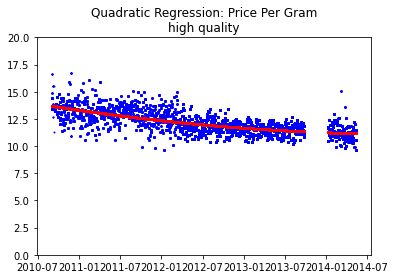

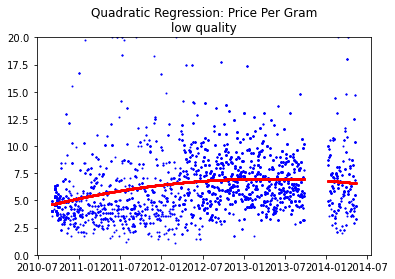

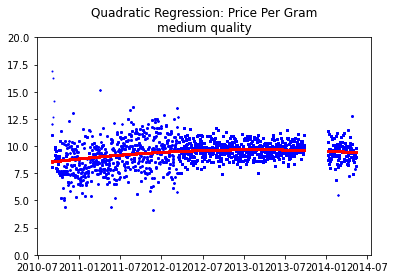

In [5]:
#//*** Plot the Quadratic Regression for each quality group.
#//*** Helps gets a feel for the current data set
for group in transactions.groupby('quality'):
    name=group[0]
    group = group[1]
    results = qmodel_patsy_ols( group,"ppg_avg_day ~ year_part + year_part2",summary=False,method="ols",getresults=True)
    labels = ['ppg','predict']
    plt.scatter(group['date'],group['ppg_avg_day'],1,'b',label=labels[0])
    plt.scatter( group['date'],results.predict(),1,'red',label=labels[1] )
    plt.legend=labels
    plt.title(f"Quadratic Regression: Price Per Gram\n{name} quality")
    plt.ylim(0,20)
    plt.show()

    

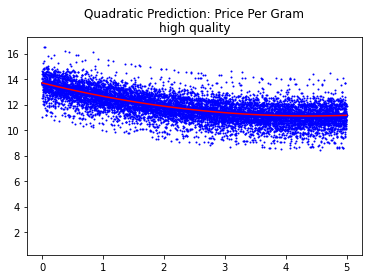

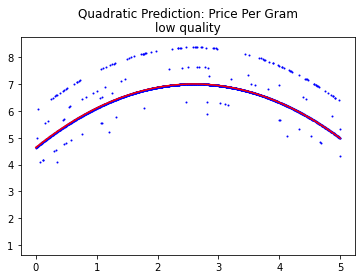

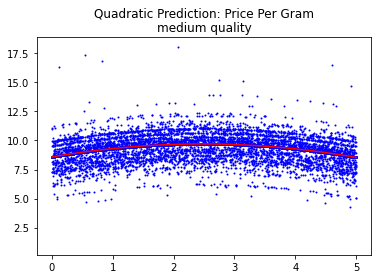

In [6]:
#//*** Plot future predictions by adding randomized residuals to the model predictions.
labels= []
#fig,ax = plt.subplots()
for group in transactions.groupby('quality'):
    name=group[0]
    group = group[1]
    results = qmodel_patsy_ols( group,"ppg_avg_day ~ year_part + year_part2",summary=False,method="ols", getresults=True)
    
    
    
    #//*** Generate future prediction based on prediction slope.
    
    #//*** Generate an evenly spaced array from 0-5 to simulate # of Years. Fill with 12*5=60 representing a predicted 
    #//*** price per month 
    years = np.linspace(0, 5, int( len(group)/4)) 
    
    #//*** Create empty intercept array, same length as years
    inter = np.ones(len(years))

    #//*** Create a dictionary:
    #//*** Inter: Array of ones
    #//*** Years - Evenly spaced array from 0-5
    #//*** Years2 - exponent of Years.
    d = dict(Intercept=inter, year_part=years, year_part2=years**2)
    
    #//*** Convert dictionary to DataFrame
    predict_df = pd.DataFrame(d)
    
    #//*** Generate predictions based off the year_part & year_part2 values to generate predicted prices
    #//*** This is a quadratic prediction
    predict_df['predict'] = results.predict(predict_df)
    
    #//*** Generate fake data
    predict_df['residuals'] = results.resid
    
    predict_df['residuals'] = predict_df['residuals'].replace(np.nan,0)
    #//*** Randomize / Resample the Residuals & add to existing Predictions
    predict_df['random_residuals'] = np.random.choice(predict_df['residuals'],len(years))
    predict_df['random_predictions'] = predict_df['random_residuals'] + predict_df['predict']
    
    
    labels.append(name)
    #plt.scatter(group['date'],group['ppg_avg_day'],1,'b')
    plt.plot( predict_df['year_part'], predict_df['predict'],1,color='red',label=name )
    #plt.ylim(0,20)
    
    plt.scatter( predict_df['year_part'], predict_df['random_predictions'],1,color='blue',label=name )
    
#plt.legend(labels)
    plt.title(f"Quadratic Prediction: Price Per Gram\n{name} quality")
    plt.show()
    

This is as far as I can go with predictions. I understand GeneratePredictions, which is basically randomizing the residuals to generate fake values. I'm completely lost on thinkstats2.PercentileRows. It looks like a method for getting the confidence intervals from the data, which have covered before. But previous instances involved getting the confidence interval from a collection of binned data. This is different and I don't understand it. Therefore it is as far as I can go.

Thinkstats code:

predict_seq = GeneratePredictions(result_seq, years, add_resid=True)

low, high = thinkstats2.PercentileRows(predict_seq, percents)

thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

- ## Chapter 12, Exercise 2

**Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

I incorporated serial correlation tests into the function I created for chapter 10. Correlations were tested against high, medium, low quality groups with lag values of 1,7,30,90,120,365.

In [7]:
# //*** Combine the Hypothesis tests into a single function for display. To keep things tidy
def display_hypothesis(input_type, input_data1, input_data2, **input_dict):
    
    input_lag = 1
    resample_test = False
    input_percentages=[.05,.1,.2,.5,.75]
    input_iter=50
    for key,value in input_dict.items():
        if key == 'lag':
            input_lag = value
        if key == 'resample_test':
            resample_test = value
        if key == 'input_percentages':
            input_percentages = value
        if key == 'input_iter':
            input_iter = value

    #//*** Compute the input_data2 value for serial correlation
    if input_type == 'serial_correlation':
        #//*** Calculate the correlation between a collection of values and an offset (lag). 
        #//*** A lag of 1, correlates with the previous value. This is exactly what we did with the COVID algorithm
        #//*** Automatically convert data1 to Series if needed
        if isinstance(input_data1, pd.Series) == False:
            input_data1 = pd.Series(data=input_data1)
        #//*** Trim lag length from data
        base_data = input_data1[input_lag:].copy()
        #//*** Trim lag length from data, pd.Series.shift takes lag values from the top and append to the bottom.
        #//*** pd.Series does most of the index handling for us
        input_data2 = input_data1.shift(input_lag)[input_lag:].copy()
        input_data1 = base_data.copy()
        
    
    test_statistic = get_test_stat(input_type,input_data1,input_data2)
        
    p_vals_test_statistic = [ hypothesis_test({ 'type':input_type,'data':(input_data1,input_data2) }) for i in range(input_iter) ]
    
    test_name = "Test: XXXX"
    
    if input_type == 'mean_diff':
        test_name = "Mean Difference"
        
    elif input_type == 'mean_diff_one_sided':
        test_name = "One Sided Mean Difference"

    elif input_type == 'cor_pearson':
        test_name = "Pearson's Correlation"

    elif input_type == 'std_diff':
        test_name = "Standard Deviation Difference"
        
    elif input_type == 'chi-squared':
        test_name = "Chi-Squared"
    elif input_type == 'serial_correlation':
        test_name = "Serial Correaltion"
        
    print(f"=======================================================")
    print(f"{test_name}: {test_statistic}")
    print(f"p-val: {np.mean(p_vals_test_statistic)} [ \u03C3: {np.std(p_vals_test_statistic)} ]")
    print(f"=======================================================")
    
    if resample_test == False:
        return
    
    for x in input_percentages:
        pvals = [ hypothesis_test({ 'type':'mean_diff','data':(input_data1,input_data2),'sample':x }) for i in range(input_iter) ]
        pvals = np.array(pvals)
        pstd = np.std(pvals)
        #print(f"================================================================================================")
        if x == 1:
            x = x*10
        print(f"Sample size {round(x*100,2)}%: p-val: {round(np.mean(pvals),4)} [ \u03C3: {pstd} ]")
        print(f"================================================================================================")

    # //*** END display_hypothesis


def hypothesis_test(input_dict):
    
    if 'type' not in input_dict.keys():
        print(f"hypothesis test requires a type value")
        return ""
    
    if 'data' not in input_dict.keys():
        print(f"Need valid data")
        return ""
    
    # //*** Assign the total number of tests to run.
    # //*** Defaults to 1000
    if 'count' in input_dict.keys():
        max_test_count = input_dict['count']
    else:
        max_test_count = 1000
    
    test_statistic = -1
    

    # //*** Convert data to Lists
    data1 = input_dict['data'][0]
    data2 = input_dict['data'][1]

    # //*** Sample a random subset of data
    # //*** Defaults to all data
    if 'sample' in input_dict.keys():
        # //*** Get random sample and convert to list
        data1 = getSample_from_series(data1,input_dict['sample'])[0]
        data2 = getSample_from_series(data2,input_dict['sample'])[0]
        
        
    
    #data1 = list(data1)
    #data2 = list(data2)

    # //*** Concatinate the lists
    combined_data = np.hstack( (data1,data2) )
    
    n = int( len(combined_data) / 2) 

    
    # //*** get the test statistic. Function performs calculation based on type
    # //*** Assume data has been properly validated at this point.
    test_statistic = get_test_stat(input_dict['type'],data1,data2)
    
    null_count = 0
    # //*** Build random permutations
    for loop_counter in range(max_test_count):
        
        # //*** randomly shuffle the combined data
        np.random.shuffle(combined_data)
        
        
        # //*** Split shuffled data evenly
        data1,data2 = combined_data[0:n],combined_data[n:len(combined_data)]
        
        loop_test_statistic = get_test_stat(input_dict['type'],data1,data2)
        
        # //*** If loop test statistic greater than test statistic. Then add to null count
        if loop_test_statistic > test_statistic:
            null_count = null_count + 1
        
    return (null_count / max_test_count)

def get_test_stat(input_ts_type, data1, data2, **input_dict):
    import scipy
    #//*** Assign optional kwargs of input_dict
    input_lag = 1
    for key,value in input_dict.items():
        if key == 'lag':
            input_lag = value
            
    if input_ts_type ==  'mean_diff':
        return abs( np.mean(data1) - np.mean(data2) )  
    
    if input_ts_type ==  'mean_diff_one_sided':
        return np.mean(data1) - np.mean(data2)
    
    if input_ts_type ==  'std_diff':
        return  np.std(data1) - np.std(data2)

    if input_ts_type ==  'cor_pearson':
        return  scipy.stats.pearsonr(data1,data2)
    
    if input_ts_type == 'serial_correlation':

        corr = scipy.stats.pearsonr(data1,data2)

        return corr
    
    # //*** Chi Squared Reference
    # https://www.geeksforgeeks.org/python-pearsons-chi-square-test/
    if input_ts_type == 'chi-squared':
        
        if isinstance(data1, pd.Series) == False:
            data1 = pd.Series(data=data1)
        if isinstance(data2, pd.Series) == False:
            data2 = pd.Series(data=data2)
            
        # Chi squared is sum( (observed - expected) ** 2 / expected )
        # observed = histogram of values
        # expected is a PMF from histogram of data1 and data2 combined with each value multipled by the total number of values.
        # perform chi on each data set and add them together for the result
        # //*** Observed is a histgram of the data
        observed1 = data1.value_counts().sort_index()
        # //*** Expectation:
        # //*** 1. Concatenate both data sets.
        # //*** 2. Convert to pd.Series
        # //*** 3. Build histogram of both data sets
        # //*** 4. build a PMF from pd.Series
        # //*** 5. Multiply each Series value by length of data1
        expectation_pmf1 = build_pmf(pd.Series(data=np.hstack( (data1,data2) ) ).value_counts().sort_index()) * len(data1)
        expectation_pmf2 = build_pmf(pd.Series(data=np.hstack( (data1,data2) ) ).value_counts().sort_index()) * len(data2)

        # //*** Build a list of the difference of observed - expectations
        # //*** Since expectations and observed are of different lengths, on the values with the same index are compared
        difference1 = np.array ( [ observed1[x] - expectation_pmf1[x] for x in observed1.index ] )
        # //*** Sampe process to build the expectations
        expectation1 = np.array( [ expectation_pmf1[x] for x in observed1.index ] )

        observed2 = data2.value_counts().sort_index()
        difference2 = np.array ( [ observed2[x] - expectation_pmf2[x] for x in observed2.index ] )
        expectation2 = np.array( [ expectation_pmf2[x] for x in observed2.index ] )

        # //*** Once the differences and expectations are of identical length, they can be plugged into the formula
        stat1 = sum( (difference1**2)/expectation1 )
        stat2 = sum( (difference2**2)/expectation2 )
        
        # //*** Return the sum of the stats
        return stat1 + stat2

        

    return ""

#print(f"{scipy.stats.pearsonr(total_weight['totalwgt_lb'],total_weight['agepreg'])}")
#correlation Testing
#Testing Proportions
#Chi Squared test

#Difference of Means Permutation test
# Generate a test statistic for reference.
# This is the difference of the means
# test statistic or t-value is the abs(difference of means)
# combine both data sets.
# 1000 thousand times:
#      Randomly split combined data in half.
#      Find the difference of the means for the random samples, for a random sample test statistic
#      count the random test statistics that are greater than the base line test statistic
# The P-value is the count / total tests run (1000)
# The P-value represents the chance of the outcome occuring randomly.
# Reference: https://www.ohbmbrainmappingblog.com/blog/a-brief-overview-of-permutation-testing-with-examples

# //*** I initially built a random sampler to perform permutations.
# //*** In hidsight I could have used np.random.shuffle and grabbed smaller sampling slices 
def getSample_from_series(input_df,input_percentage=.1):
    #//*** Returns a random sampling of the input_df or Series
    # //*** Series type conversion to dataFrame
    
    is_series = False
    
    if isinstance(input_df, pd.Series):
        input_df = pd.DataFrame(input_df)
        is_series = True
    
    sample_size = int(len(input_df) * input_percentage)
    remainder_size = len(input_df) - sample_size
    
    #print(f"{sample_size} {remainder_size}")
    
    # //*** Set Loop safety as a function of sample_size and input_percentage
    loop_safe_max = (sample_size * 1/input_percentage)**2
    #print(f"Loop Safe Max: {loop_safe_max}")
    
    loop_safe = 0
    sample_index = []
    sample_dict = {}
    
    # //*** Get a random integer between 0 and size of input_series -1
    # //*** Build a list of unique random numbers equal to the sample size
    # //*** A dictionary is used to keep track of unique values.
    while len(sample_index) < sample_size:
        # //*** Pick a random integer between - and len(input_df) -1 
        random_int = np.random.randint( (len(input_df)-1) )
        
        #//*** Convert integer to index key
        random_int = input_df.index[random_int]
        
               
        
        #//*** Check if we've used this number
        if random_int not in sample_dict.keys():
            sample_index.append(random_int)
            sample_dict[random_int] = ""
        
        loop_safe = loop_safe + 1
        
        if loop_safe > loop_safe_max:
            print("Loop Maximum exceeded! Quitting for Safety!")
            break;
    
    #//*** Sort the values
    sample_index = np.sort(sample_index)
    
    #//*** Build a list of values, 1 is sample, 0 is not sample
    #//*** This will be a column to add to the input_df
    is_sample = []
    for x in input_df.index:
        if x in sample_index:
            is_sample.append(1)
        else:
            is_sample.append(0)
    
    #//*** Add is_sample column
    input_df = input_df.assign( is_sample = is_sample)
    
    # //*** get sample and remainder dataframes based on is_sample attribute
    # //*** Get the sample data frame and the remainder dataframe
    sample_df = input_df[input_df ['is_sample'] == 1]
    remainder_df = input_df[input_df ['is_sample'] == 0 ]
    
    # //**** Remove is_Sample Parameter
    del sample_df['is_sample']
    del remainder_df['is_sample']
    
    #print(len(sample_index))
    #print(len(sample_df))

    
    if is_series == True:
        sample_df = pd.Series(index= sample_df.index, data= sample_df.iloc[:,0])
        remainder_df = pd.Series(index= remainder_df.index, data= remainder_df.iloc[:,0])
    return sample_df, remainder_df

**Serial Correlation of average price data:**

In [8]:
quality_groups =  transactions.groupby('quality')

#//*** split groups by quality
for quality_group in quality_groups:
    #//*** Get a friendly df name
    df = quality_group[1]
    
    #//*** get the ppg_avg_day. 
    #//*** Loop through each unique date, get first value of ppg_avg_day, 
    #//*** Being pythonic is getting almost as bad as javascript
    ppg_avg_day = [df [df['date'] == i]['ppg_avg_day'].iloc[0] for i in df['date'].unique() ]
    
    lag = 1
    #//*** Correllate with lag of 1
    

    #corr = get_test_stat('serial_correlation', ppg_avg_day,[], lag=1)
    #print(f"{corr}")
    for x in [1,7,30,90,120,365]:
        print(f"Quality: {quality_group[0]} Correlated Days (lag): {x}")
        display_hypothesis('serial_correlation', ppg_avg_day, [], lag=x)
        
    

            

Quality: high Correlated Days (lag): 1
Serial Correaltion: (0.48522937619473805, 3.144306439363242e-74)
p-val: 0.0 [ σ: 0.0 ]
Quality: high Correlated Days (lag): 7
Serial Correaltion: (0.4847933897197953, 9.92389609781594e-74)
p-val: 0.0 [ σ: 0.0 ]
Quality: high Correlated Days (lag): 30
Serial Correaltion: (0.46350554293376683, 1.5716869584481634e-65)
p-val: 0.0 [ σ: 0.0 ]
Quality: high Correlated Days (lag): 90
Serial Correaltion: (0.42849557915175307, 1.3297276305893593e-52)
p-val: 0.0 [ σ: 0.0 ]
Quality: high Correlated Days (lag): 120
Serial Correaltion: (0.4084290500092257, 2.626890321826373e-46)
p-val: 0.0 [ σ: 0.0 ]
Quality: high Correlated Days (lag): 365
Serial Correaltion: (0.3403450179460916, 3.3927635158404396e-25)
p-val: 0.0 [ σ: 0.0 ]
Quality: low Correlated Days (lag): 1
Serial Correaltion: (0.11657497441101058, 6.0585184051829546e-05)
p-val: 0.0002 [ σ: 0.0004898979485566357 ]
Quality: low Correlated Days (lag): 7
Serial Correaltion: (0.04047056079327584, 0.1661816478

**Serial Correlation: residuals of the Linear model**

In [9]:
#//*** split groups by quality
for quality_group in quality_groups:
    #//*** Get a friendly df name
    df = quality_group[1]

    #results = qmodel_patsy_ols( quality_group[1],"ppg_avg_day ~ year_part + year_part2",summary=False,method="ols", getresults=True)
    results = qmodel_patsy_ols( quality_group[1],"ppg_avg_day ~ year_part",summary=False,method="ols", getresults=True)

    print(f"=================================")
    print(f"Correlated Linear Residuals")
    print(f"Quality: {quality_group[0]}" )
    print(f"=================================")

    for x in [1,7,30,90,120,365]:
        print(f"Correlated Days (lag): {x}")
        display_hypothesis('serial_correlation', results.resid, [], lag=x,input_iter=5)
        
 

Correlated Linear Residuals
Quality: high
Correlated Days (lag): 1
Serial Correaltion: (0.9764184918543657, 0.0)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 7
Serial Correaltion: (0.8378791936522925, 0.0)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 30
Serial Correaltion: (0.4789268276632913, 0.0)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 90
Serial Correaltion: (0.17748551959264097, 0.0)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 120
Serial Correaltion: (0.13194641806346402, 2.4497205951422088e-293)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 365
Serial Correaltion: (0.09088162533396893, 3.542981193076968e-139)
p-val: 0.0 [ σ: 0.0 ]
Correlated Linear Residuals
Quality: low
Correlated Days (lag): 1
Serial Correaltion: (0.6940287142975101, 0.0)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 7
Serial Correaltion: (0.08390632304719002, 3.334319864845093e-11)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 30
Serial Correaltion: (0.060993596139997636, 1.529745318800972e-06)
p-val: 0.0 [ σ

**Serial Correlation: residuals of the Quadratic model**

In [10]:
#//*** split groups by quality
for quality_group in quality_groups:
    #//*** Get a friendly df name
    df = quality_group[1]

    #results = qmodel_patsy_ols( quality_group[1],"ppg_avg_day ~ year_part + year_part2",summary=False,method="ols", getresults=True)
    results = qmodel_patsy_ols( quality_group[1],"ppg_avg_day ~ year_part + year_part2",summary=False,method="ols", getresults=True)

    print(f"=================================")
    print(f"Correlated Quadratic Residuals")
    print(f"Quality: {quality_group[0]}" )
    print(f"=================================")

    for x in [1,7,30,90,120,365]:
        print(f"Correlated Days (lag): {x}")
        display_hypothesis('serial_correlation', results.resid, [], lag=x,input_iter=5)
        
 

Correlated Quadratic Residuals
Quality: high
Correlated Days (lag): 1
Serial Correaltion: (0.975309148104418, 0.0)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 7
Serial Correaltion: (0.8302354680193689, 0.0)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 30
Serial Correaltion: (0.4541254730486279, 0.0)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 90
Serial Correaltion: (0.13805744329849595, 2.53e-321)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 120
Serial Correaltion: (0.09051996423427539, 1.6032463990932375e-138)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 365
Serial Correaltion: (0.04967250270680564, 9.328667237738798e-43)
p-val: 0.0 [ σ: 0.0 ]
Correlated Quadratic Residuals
Quality: low
Correlated Days (lag): 1
Serial Correaltion: (0.6870198957995342, 0.0)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 7
Serial Correaltion: (0.06318474458145468, 6.051150274820283e-07)
p-val: 0.0 [ σ: 0.0 ]
Correlated Days (lag): 30
Serial Correaltion: (0.03986050241547392, 0.0016895157981087609)
p-val